In [1]:
# Link to the GitHub Repository that implements these time-series features: https://github.com/facebookresearch/Kats/
# Using Python 3.9.6 (for Kats)
import pandas as pd # pandas 1.4.1
import numpy as np # numpy 1.22.3
from kats.consts import TimeSeriesData # kats 0.2.0
from kats.tsfeatures.tsfeatures import TsFeatures # kats 0.2.0

In [10]:
# File path goes to the raw accelerometer data file
df_raw = pd.read_csv('~/human-activity-recognition/raw-data/har_raw.gz')

df_raw['acceleration'] = np.linalg.norm(df_raw.loc[:,['x','y','z']],axis=1) # magnitude of acceleration
df_raw['is_STF'] = 0 # set all to false first; other-classified events are False (0)
df_raw.loc[df_raw['motion'] != 'other','is_STF'] = 1 # set slip, trips, fall-events to True (1)
df_raw['time'] = df_raw['milliseconds'] / 10**3 # Converts the time to seconds

incident_id = list(set(df_raw['incident_id'])) # list of unique incident ids

ts_list = [] # list of time series
ts_stf = [] # labels of time series

# Need this structure in order to generate features using Kats library
for i in incident_id:
    temp = df_raw.loc[df_raw['incident_id'] == i,['time','acceleration']].reset_index(drop=True)
    ts_list.append(TimeSeriesData(temp, use_unix_time=True, unix_time_units="s"))
    ts_stf.append(df_raw.loc[df_raw['incident_id'] == i,'is_STF'].reset_index(drop=True)[0])

<AxesSubplot:xlabel='time'>

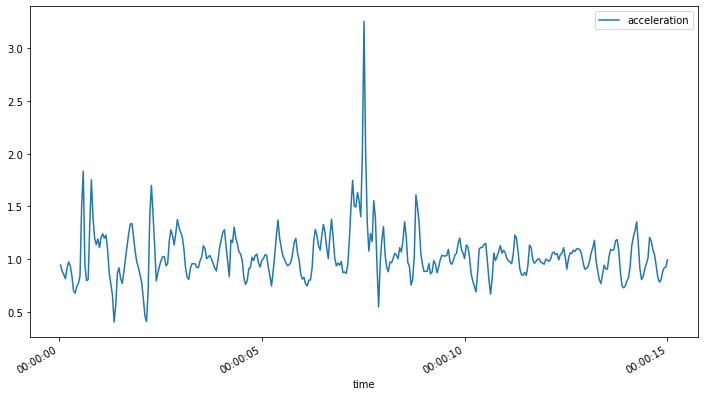

In [11]:
# This is what the data looks like!
ts_list[0].plot(cols=['acceleration'])

In [14]:
# There are a bunch of repeated warnings, so this is just so that there isn't any warning spam
import warnings
warnings.filterwarnings(action='once')

# These are features we do not what to calculate because they are very small or no added value:
# 'length','holt_beta','hw_alpha','hw_beta','hw_gamma'
model = TsFeatures(length = False,
                   holt_beta = False,
                   hw_alpha = False,
                   hw_beta = False,
                   hw_gamma = False)

output_features = [] # list that holds all the generated features

# loop through time series data and perform transformation
for count, ts in enumerate(ts_list):
    output_features.append(model.transform(ts))
    
df_features = pd.DataFrame(output_features) # converting to dataframe
df_features.head()

/scratch/brown/kamstut/tdm/apps/jupyter/kernels/f2021-s2022/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/scratch/brown/kamstut/tdm/apps/jupyter/kernels/f2021-s2022/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/scratch/brown/kamstut/tdm/apps/jupyter/kernels/f2021-s2022/.venv/lib/python3.9/site-packages/kats/tsfeatures/tsfeatures.py:701: RuntimeWarning:

divide by zero encountered in log2

/scratch/brown/kamstut/tdm/apps/jupyter/kernels/f2021-s2022/.venv/lib/python3.9/site-packages/kats/tsfeatures/tsfeatures.py:701: RuntimeWarning:

invalid value encountered in multiply



,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,binarize_mean,...,diff2y_acf1,diff2y_acf5,y_pacf5,diff1y_pacf5,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha
0,1.039518,0.057431,0.809962,0.003984,0.011404,1,0.028947,0.135495,68,0.434667,...,-0.193737,0.167602,0.718425,0.258514,0.449012,0.107697,-0.110581,4,9,1.0
1,1.049553,0.077127,0.810086,0.006761,0.008090,1,0.070263,0.156361,73,0.426667,...,-0.296334,0.131851,0.627766,0.163948,0.354465,0.094137,0.083017,5,5,1.0
2,1.011825,0.076712,0.746206,0.010516,0.012797,1,0.039119,0.140111,84,0.421333,...,-0.027039,0.107896,1.104883,0.385651,0.186040,-0.311432,-0.040773,7,4,1.0
3,0.989660,0.073126,0.763240,0.025195,0.013343,2,0.077748,0.129363,95,0.288000,...,-0.088448,0.124625,1.018029,0.304377,0.238531,-0.069282,0.006049,9,6,1.0
4,0.990557,0.041613,0.856353,0.008232,0.004109,1,0.020958,0.126226,103,0.410667,...,-0.376831,0.179549,0.454550,0.124631,0.490727,-0.111499,-0.028206,4,4,1.0


In [16]:
df_features['is_STF'] = ts_stf # Adds is_STF label to each data point
df_features.to_csv('timeseriesfeatures_kats.csv',index=False) # exports .csv file so that you don't have to repeat this again

/scratch/brown/kamstut/tdm/apps/jupyter/kernels/f2021-s2022/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Using PyCaret to see if these time-series features make better models

In [2]:
# Using Python 3.8.12 (for PyCaret)
from pycaret.classification import * # pycaret 2.3.6
import pandas as pd # pandas 1.4.1
import numpy as np # numpy 1.22.3

In [3]:
df_features = pd.read_csv('timeseriesfeatures_kats.csv') # read in time-series features from Kats

# Initial setup of the PyCaret models
# This implements SMOTE for the class imbalance, and performs a Yeo-Johnson transformation then normalization.
# Also tries to use PyCaret's built in feature selection workflow to reduce feature space
clf1 = setup(data = df_features, target = 'is_STF', fix_imbalance = True,transformation = True,normalize=True,
            feature_selection = True, feature_selection_threshold = 0.5,silent=True)

,Description,Value
0,session_id,4623
1,Target,is_STF
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2770, 36)"
5,Missing Values,0
6,Numeric Features,32
7,Categorical Features,3
8,Ordinal Features,0
9,High Cardinality Features,0


In [4]:
best = compare_models(sort='precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8865,0.5349,0.0093,0.2000,0.0178,0.0066,0.0235,1.0810
gbc,Gradient Boosting Classifier,0.8793,0.4951,0.0281,0.1810,0.0478,0.0192,0.0314,2.6090
dt,Decision Tree Classifier,0.7668,0.5194,0.2028,0.1309,0.1579,0.0303,0.0318,0.0970
knn,K Neighbors Classifier,0.5655,0.5382,0.5106,0.1284,0.2050,0.0365,0.0522,0.1100
lightgbm,Light Gradient Boosting Machine,0.8777,0.5192,0.0186,0.1200,0.0321,0.0037,0.0077,0.4770
nb,Naive Bayes,0.1785,0.4804,0.9435,0.1123,0.2008,0.0066,0.0317,0.0230
lda,Linear Discriminant Analysis,0.5640,0.4954,0.4405,0.1123,0.1787,0.0063,0.0116,0.0810
ridge,Ridge Classifier,0.5614,0.0000,0.4405,0.1117,0.1779,0.0051,0.0098,0.0800
qda,Quadratic Discriminant Analysis,0.1806,0.4892,0.9297,0.1113,0.1988,0.0042,0.0162,0.0830
svm,SVM - Linear Kernel,0.5133,0.0000,0.4827,0.1092,0.1770,-0.0003,-0.0002,0.0790
